In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp /content/kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

 99% 1.13G/1.14G [00:22<00:00, 65.7MB/s]
100% 1.14G/1.14G [00:22<00:00, 54.2MB/s]


In [ ]:
!unzip "/content/pneumonia-xray-images.zip" -d "/content/pneumonia-xray-images"

Streaming output truncated to the last 5000 lines.
  inflating: /content/pneumonia-xray-images/train/normal/IM-0435-0001-0001.jpeg  
  inflating: /content/pneumonia-xray-images/train/normal/IM-0435-0001.jpeg  
  inflating: /content/pneumonia-xray-images/train/normal/IM-0437-0001-0001.jpeg  
  inflating: /content/pneumonia-xray-images/train/normal/IM-0437-0001-0002.jpeg  
  inflating: /content/pneumonia-xray-images/train/normal/IM-0437-0001.jpeg  
  inflating: /content/pneumonia-xray-images/train/normal/IM-0438-0001.jpeg  
  inflating: /content/pneumonia-xray-images/train/normal/IM-0439-0001-0001.jpeg  
  inflating: /content/pneumonia-xray-images/train/normal/IM-0439-0001-0002.jpeg  
  inflating: /content/pneumonia-xray-images/train/normal/IM-0439-0001.jpeg  
  inflating: /content/pneumonia-xray-images/train/normal/IM-0440-0001.jpeg  
  inflating: /content/pneumonia-xray-images/train/normal/IM-0441-0001.jpeg  
  inflating: /content/pneumonia-xray-images/train/normal/IM-0442-0001.jpeg  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
path_train ='/content/pneumonia-xray-images/train'
path_test = '/content/pneumonia-xray-images/test'
path_val = '/content/pneumonia-xray-images/val'

In [ ]:
#setting up some parameters to be used
batch_size = 24 
img_height = 320
img_width = 320

In [ ]:
## importing libraries for working with image data 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#data generator for training set
image_gen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2,horizontal_flip = True)

In [ ]:
#data generator for testing set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
#reading image data from folder
train = image_gen.flow_from_directory(
      path_train,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

Found 4192 images belonging to 2 classes.


In [ ]:
test = test_data_gen.flow_from_directory(
      path_test,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, 
      class_mode='binary',
      batch_size=batch_size
      )
#shuffling is false for later comparison
#but in deployement generator it will be true

Found 624 images belonging to 2 classes.


In [ ]:
valid = test_data_gen.flow_from_directory(
      path_val,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 1040 images belonging to 2 classes.


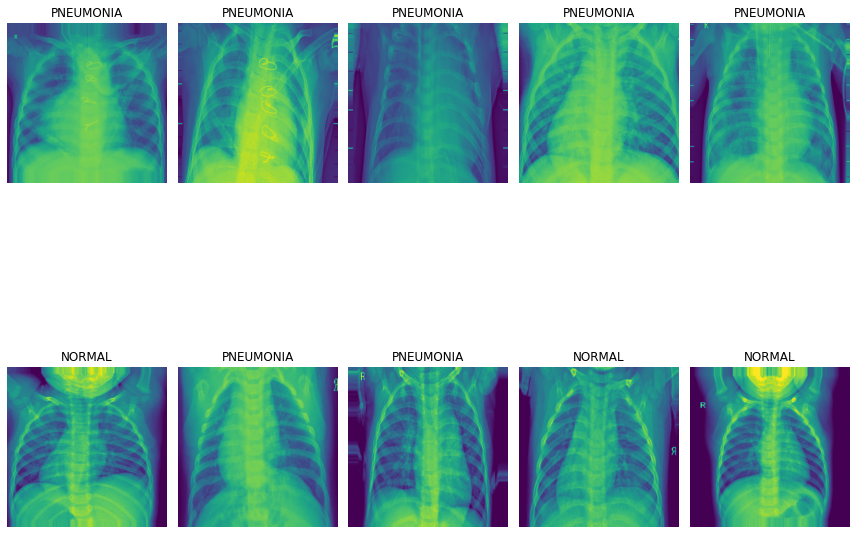

In [52]:
#now visualing the image data loaded into ram
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image))
        break
plt.tight_layout()
plt.show()

In [ ]:
#importing other model creation files and backend handelling library

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [ ]:
#creating model

model_ver5 = Sequential()

In [ ]:
model_ver5.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
model_ver5.add(MaxPooling2D(pool_size = (2, 2)))
model_ver5.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
model_ver5.add(MaxPooling2D(pool_size = (2, 2)))
model_ver5.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
model_ver5.add(MaxPooling2D(pool_size = (2, 2)))
model_ver5.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
model_ver5.add(MaxPooling2D(pool_size = (2, 2)))
model_ver5.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
model_ver5.add(MaxPooling2D(pool_size = (2, 2)))
model_ver5.add(Flatten())
model_ver5.add(Dense(activation = 'relu', units = 128))
model_ver5.add(Dense(activation = 'relu', units = 64))
model_ver5.add(Dense(activation = 'sigmoid', units = 1))

In [ ]:
model_ver5.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
model_ver5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 318, 318, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 159, 159, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 157, 157, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 78, 78, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 76, 76, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 38, 38, 32)       0

In [ ]:
# Setting some  Hyperparameters 
# Hyperparameters of MaxPooling2D 
MaxPooling2D(
    pool_size=(2, 2), strides=None, padding="valid"
    )

In [ ]:
#visualizing model plot
from tensorflow.keras.utils import plot_model

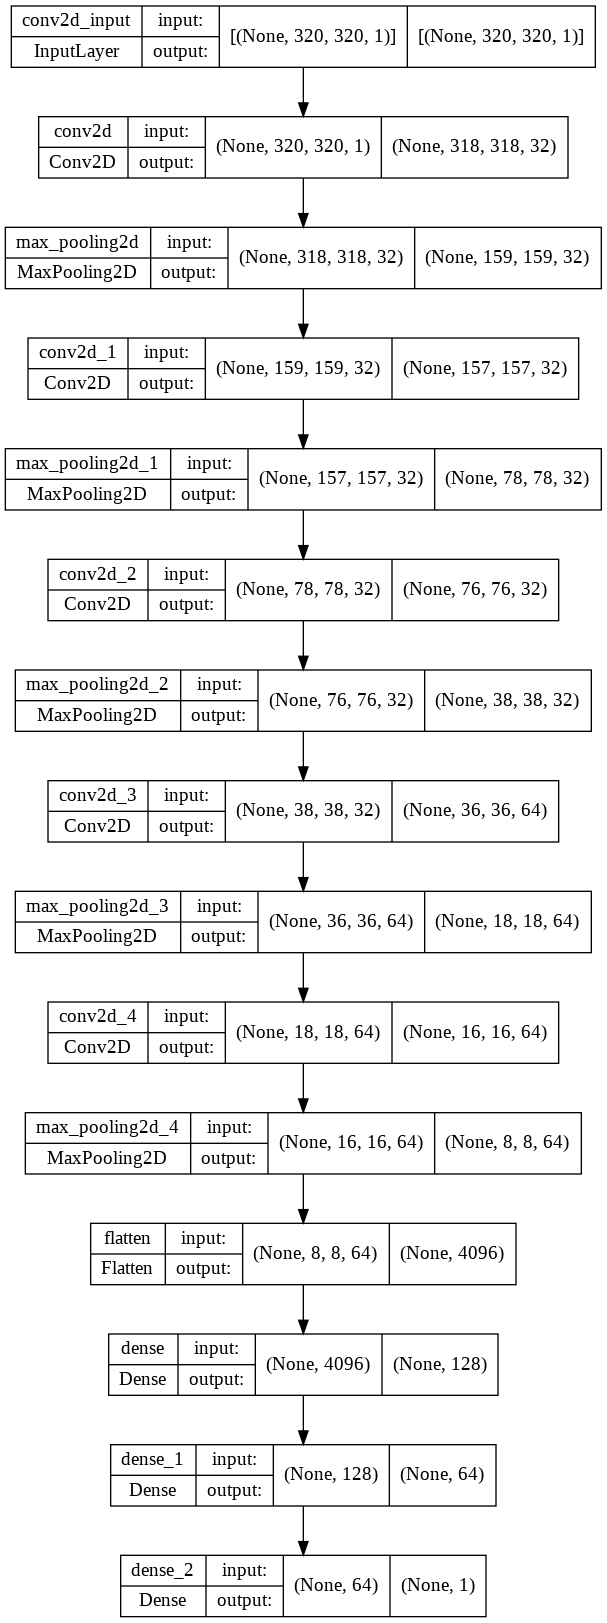

In [ ]:
plot_model(model_ver5,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [ ]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [ ]:
#taking class weights
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(class_weight='balanced',classes= np.unique(train.classes),y=train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.9371534195933457, 1: 0.6739549839228296}


In [ ]:
#fiiting data and training the model
model_ver5.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
175/175 [==============================] - 406s 2s/step - loss: 0.3682 - accuracy: 0.8156 - val_loss: 0.3201 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 2/25
175/175 [==============================] - 398s 2s/step - loss: 0.2662 - accuracy: 0.8943 - val_loss: 0.1896 - val_accuracy: 0.9471 - lr: 0.0010
Epoch 3/25
175/175 [==============================] - 394s 2s/step - loss: 0.2363 - accuracy: 0.9043 - val_loss: 0.3636 - val_accuracy: 0.8404 - lr: 0.0010
Epoch 4/25
175/175 [==============================] - ETA: 0s - loss: 0.1873 - accuracy: 0.9268
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
175/175 [==============================] - 395s 2s/step - loss: 0.1873 - accuracy: 0.9268 - val_loss: 0.2879 - val_accuracy: 0.8760 - lr: 0.0010
Epoch 5/25
175/175 [==============================] - 396s 2s/step - loss: 0.1620 - accuracy: 0.9354 - val_loss: 0.1851 - val_accuracy: 0.9327 - lr: 3.0000e-04
Epoch 6/25
175/175 [==============================] - 3

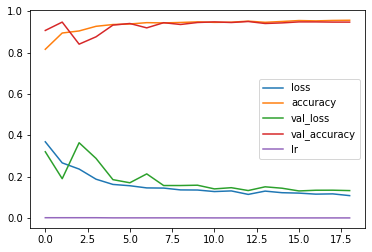

In [ ]:
pd.DataFrame(model_ver5.history.history).plot()

In [ ]:
test_accu = model_ver5.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

26/26 [==============================] - 17s 648ms/step - loss: 0.3008 - accuracy: 0.9151
The testing accuracy is : 91.50640964508057 %


In [ ]:
preds = model_ver5.predict(test,verbose=1)

26/26 [==============================] - 17s 620ms/step


In [ ]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

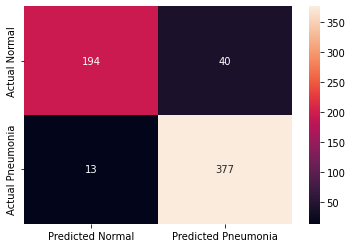

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.94      0.83      0.88       234
   PNEUMONIA       0.90      0.97      0.93       390

    accuracy                           0.92       624
   macro avg       0.92      0.90      0.91       624
weighted avg       0.92      0.92      0.91       624



In [ ]:
model_ver5.save('/content/model_ver5.h5')

In [ ]:
model_ver5.save('model_ver5.h5')

In [ ]:
model_ver5.save_weights("model.h5")